参考  https://hrl.boyuai.com/chapter/1/%E6%97%B6%E5%BA%8F%E5%B7%AE%E5%88%86%E7%AE%97%E6%B3%95



偏差  和 方差 折衷

* 蒙特卡洛： 无偏， 但方差大
* 时序差分： 方差小， 但 偏差大


多步时序差分： 使用 **$n$ 步的奖励**，然后使用**之后状态的价值估计**。

$n$ 步 Q-learning： $Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha\Big[r_t+\gamma r_{t+1}+\cdots+\gamma^n \max\limits_{a^\prime}Q(s_{t+n},a^\prime)-Q(s_t,a_t)\Big]$

# Code

## 环境 悬崖漫步



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # 用于显示循环模块运行进度

class CliffWalkingEnv:
  def __init__(self, ncol, nrow):
    self.nrow = nrow
    self.ncol = ncol
    self.x = 0  # 记录 agent 当前的横坐标
    self.y = self.nrow - 1 # 记录 agent 当前的纵坐标

  def step(self, action):
    change = [[0, -1], [0, 1], [-1, 0], [1, 0]] # 上下左右的坐标变化量
    self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
    self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
    next_state = self.y * self.ncol + self.x
    reward = -1
    done = False
    if self.y == self.nrow - 1 and self.x > 0:# 下一位置在悬崖 或 目标位置
      done = True
      if self.x != self.ncol - 1:
        reward = -100 # 掉下悬崖了
    return next_state, reward, done

  def reset(self): #
    self.x = 0
    self.y = self.nrow - 1
    return self.y * self.ncol + self.x


## n-step Q-learning 算法

维护表格 Q_table()：存储当前策略下所有**状态-动作对**的**价值**。

采样： $\epsilon$-greedy 策略

更新 Q 值： n-step Q-learning

In [2]:
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库

class nstep_Q_learning:
    """ n 步 Q-learning 算法 """
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化 Q(s,a) 表格
        self.n_action = n_action # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.n = n  # n 步 Sarsa 算法
        # 保存之前的转换 s, a, r
        self.state_list = []
        self.action_list = []
        self.reward_list = []

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, done):
      self.state_list.append(s0)
      self.action_list.append(a0)
      self.reward_list.append(r)
      if len(self.state_list) == self.n: # 足以进行 n 步更新
        G = self.Q_table[s1].max()
        for i in reversed(range(self.n)): # 因为用到后面的状态的价值，所以从后面往前推
          G = self.gamma * G + self.reward_list[i]
          # 如果到达终止状态，最后几步若是长度不够 n 步，也进行更新
          if done and i > 0:
            s = self.state_list[i]
            a = self.action_list[i]
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        s = self.state_list.pop(0) # 去掉最旧的数据
        a = self.action_list.pop(0)
        self.reward_list.pop(0)
        self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])

      if done: # 要进行下一回合了，清空之前存储的上一回合的数据
        self.state_list = []
        self.action_list = []
        self.reward_list = []

## 训练

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 1490.04it/s, episode=500, return=-19.900]


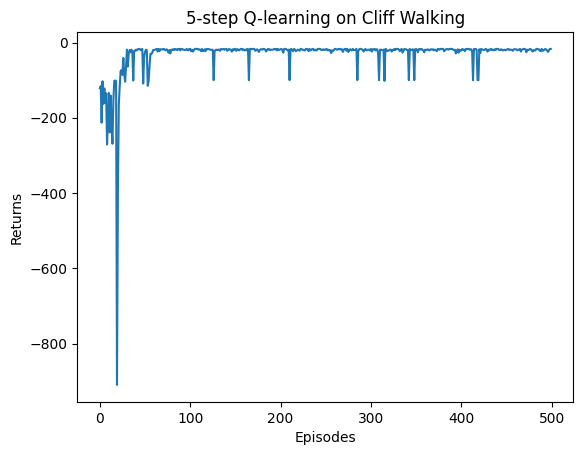

In [3]:

ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
n_step = 5 # 5 步 Q-learning
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = nstep_Q_learning(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的回合数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, done)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每 10 条序列打印一下这 10 条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Q-learning on {}'.format('Cliff Walking'))
plt.show()

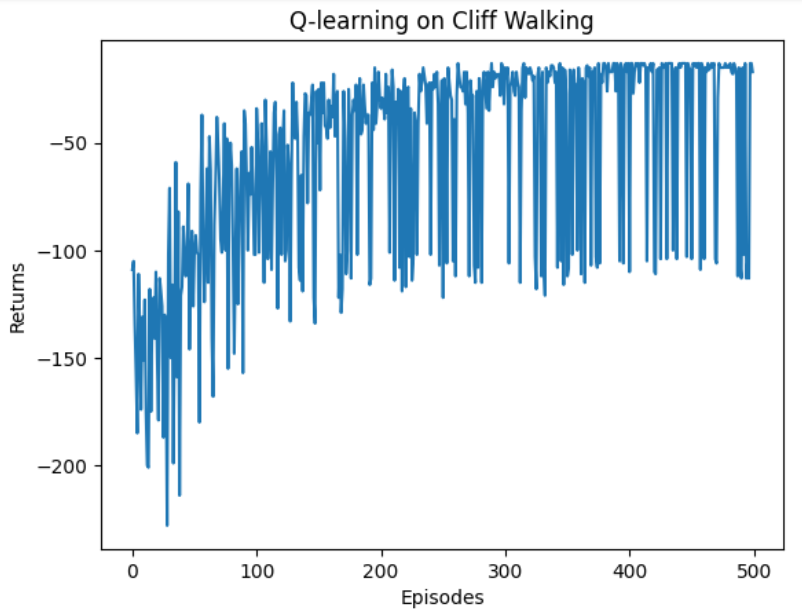

5 步 Q-learning 算法的收敛速度比单步 Q-learning 算法更快。

## 可视化


In [4]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print(' * ', end=' ')
            elif (i * env.ncol + j) in end:
                print(' E', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                  if a[k] > 0:
                    pi_str = action_meaning[k]
                    break
                print(pi_str, end='  ')
        print()


action_meaning = ['↑', '↓', '←', '→']
print('5-step Q-learning 算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

5-step Q-learning 算法最终收敛得到的策略为：
→  →  →  →  →  →  →  →  →  →  →  ↓  
↑  ↑  ↑  ↑  ↑  ↑  ←  ↑  ↑  →  →  ↓  
↑  ↑  ↑  ↑  ←  →  ↑  ↑  →  ↑  →  ↓  
↑   *   *   *   *   *   *   *   *   *   *   E 


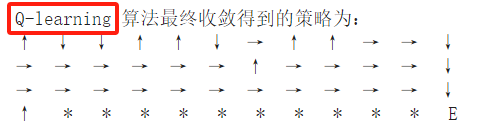

多步 Q-learning 算法得到的策略 相比 Q-learning，<font color=red>更保守 ！！！</font>。